# Pre-Paid Card Marketing

## Data Preprocessing

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import statsmodels.api as sm
from matplotlib import pyplot as plt
from scipy.stats import loguniform, randint, uniform
from sklearn.calibration import calibration_curve
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import make_scorer, classification_report, f1_score, precision_recall_curve, confusion_matrix
from sklearn.model_selection import train_test_split, StratifiedKFold, RandomizedSearchCV
from xgboost import XGBClassifier

import utils

In [3]:
df = pd.read_csv('../data/Financial Wellness Data.csv')
df

,PUF_ID,sample,fpl,SWB_1,SWB_2,SWB_3,FWBscore,FWB1_1,FWB1_2,FWB1_3,...,PPMSACAT,PPREG4,PPREG9,PPT01,PPT25,PPT612,PPT1317,PPT18OV,PCTLT200FPL,finalwt
0,10350,2,3,5,5,6,55,3,3,3,...,1,4,8,0,0,0,0,1,0,0.367292
1,7740,1,3,6,6,6,51,2,2,3,...,1,2,3,0,0,0,0,2,0,1.327561
2,13699,1,3,4,3,4,49,3,3,3,...,1,4,9,0,0,0,1,2,1,0.835156
3,7267,1,3,6,6,6,49,3,3,3,...,1,3,7,0,0,0,0,1,0,1.410871
4,7375,1,3,4,4,4,49,3,3,3,...,1,2,4,0,0,1,0,4,1,4.260668
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6389,11220,3,3,6,7,7,61,3,3,1,...,1,2,3,0,0,0,1,2,-5,0.522504
6390,13118,3,2,7,7,7,59,3,4,2,...,1,3,6,0,0,0,0,3,-5,1.015219
6391,8709,1,3,5,6,6,59,3,4,3,...,1,1,2,0,0,0,0,2,0,1.136270
6392,8515,1,3,5,5,5,46,2,2,3,...,1,4,9,0,0,0,0,2,0,1.224941


In [4]:
# find duplicates
df[df.duplicated()]

,PUF_ID,sample,fpl,SWB_1,SWB_2,SWB_3,FWBscore,FWB1_1,FWB1_2,FWB1_3,...,PPMSACAT,PPREG4,PPREG9,PPT01,PPT25,PPT612,PPT1317,PPT18OV,PCTLT200FPL,finalwt


In [5]:
# check for missing values
df.isnull().sum()

PUF_ID         0
sample         0
fpl            0
SWB_1          0
SWB_2          0
              ..
PPT612         0
PPT1317        0
PPT18OV        0
PCTLT200FPL    0
finalwt        0
Length: 217, dtype: int64

In [6]:
# check the data types
df.dtypes

PUF_ID           int64
sample           int64
fpl              int64
SWB_1            int64
SWB_2            int64
                ...   
PPT612           int64
PPT1317          int64
PPT18OV          int64
PCTLT200FPL      int64
finalwt        float64
Length: 217, dtype: object

In [7]:
# check if any features have zero variance
df.var() == 0

PUF_ID         False
sample         False
fpl            False
SWB_1          False
SWB_2          False
               ...  
PPT612         False
PPT1317        False
PPT18OV        False
PCTLT200FPL    False
finalwt        False
Length: 217, dtype: bool

## Exploratory Data Analysis

In [8]:
# Describe the data
df.describe()

,PUF_ID,sample,fpl,SWB_1,SWB_2,SWB_3,FWBscore,FWB1_1,FWB1_2,FWB1_3,...,PPMSACAT,PPREG4,PPREG9,PPT01,PPT25,PPT612,PPT1317,PPT18OV,PCTLT200FPL,finalwt
count,6394.000000,6394.000000,6394.000000,6394.000000,6394.000000,6394.000000,6394.000000,6394.000000,6394.000000,6394.000000,...,6394.000000,6394.000000,6394.000000,6394.000000,6394.000000,6394.000000,6394.000000,6394.000000,6394.000000,6394.000000
mean,10892.392712,1.279794,2.658899,5.353769,5.362215,5.432280,56.034094,3.048014,3.191899,2.531279,...,0.866124,2.644823,5.145605,0.035815,0.078511,0.129653,0.122928,2.084298,-0.081952,1.000000
std,1967.854493,0.570187,0.656944,1.500913,1.544942,1.613876,14.154676,1.235221,1.114130,1.196235,...,0.340545,1.032583,2.529397,0.185843,0.268995,0.335947,0.328380,0.814345,1.328498,0.585406
min,7123.000000,1.000000,1.000000,-4.000000,-4.000000,-4.000000,-4.000000,-4.000000,-4.000000,-4.000000,...,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,-5.000000,0.165567
25%,9235.250000,1.000000,3.000000,5.000000,5.000000,5.000000,48.000000,2.000000,3.000000,2.000000,...,1.000000,2.000000,3.000000,0.000000,0.000000,0.000000,0.000000,2.000000,0.000000,0.600582
50%,10901.500000,1.000000,3.000000,6.000000,6.000000,6.000000,56.000000,3.000000,3.000000,2.000000,...,1.000000,3.000000,5.000000,0.000000,0.000000,0.000000,0.000000,2.000000,0.000000,0.845213
75%,12570.750000,1.000000,3.000000,6.000000,7.000000,7.000000,65.000000,4.000000,4.000000,3.000000,...,1.000000,3.000000,7.000000,0.000000,0.000000,0.000000,0.000000,2.000000,0.000000,1.251415
max,14400.000000,3.000000,3.000000,7.000000,7.000000,7.000000,95.000000,5.000000,5.000000,5.000000,...,1.000000,4.000000,9.000000,1.000000,1.000000,1.000000,1.000000,4.000000,1.000000,6.638674


## Feature Engineering

In [9]:
# Split the data into features and target
X = df.drop(columns=['PUF_ID', 'PRODUSE_3'])
y = df['PRODUSE_3']

In [10]:
# drop some variables
X = X.drop(columns=['finalwt', 'PRODUSE_6'])
X

,sample,fpl,SWB_1,SWB_2,SWB_3,FWBscore,FWB1_1,FWB1_2,FWB1_3,FWB1_4,...,PPMARIT,PPMSACAT,PPREG4,PPREG9,PPT01,PPT25,PPT612,PPT1317,PPT18OV,PCTLT200FPL
0,2,3,5,5,6,55,3,3,3,3,...,3,1,4,8,0,0,0,0,1,0
1,1,3,6,6,6,51,2,2,3,3,...,3,1,2,3,0,0,0,0,2,0
2,1,3,4,3,4,49,3,3,3,3,...,3,1,4,9,0,0,0,1,2,1
3,1,3,6,6,6,49,3,3,3,3,...,3,1,3,7,0,0,0,0,1,0
4,1,3,4,4,4,49,3,3,3,3,...,1,1,2,4,0,0,1,0,4,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6389,3,3,6,7,7,61,3,3,1,3,...,1,1,2,3,0,0,0,1,2,-5
6390,3,2,7,7,7,59,3,4,2,4,...,1,1,3,6,0,0,0,0,3,-5
6391,1,3,5,6,6,59,3,4,3,3,...,1,1,1,2,0,0,0,0,2,0
6392,1,3,5,5,5,46,2,2,3,2,...,5,1,4,9,0,0,0,0,2,0


<Axes: xlabel='PRODUSE_3'>

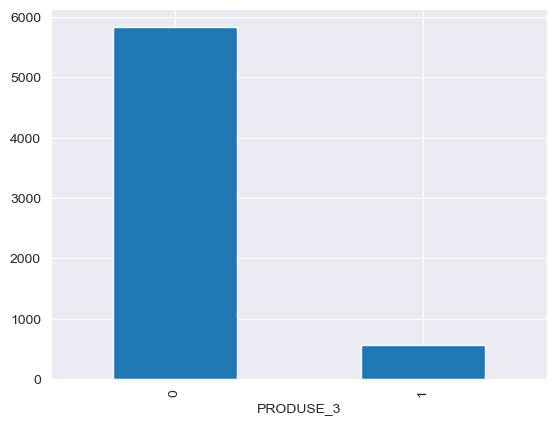

In [11]:
# plot the distribution of the target variable
y.value_counts().plot(kind='bar')

### Dummify the categorical variables

In [12]:
# dummify any integer columns
df_categorical = X.astype('object')

# dummify the categorical variables
X = pd.get_dummies(df_categorical, drop_first=True)
X

,sample_2,sample_3,fpl_2,fpl_3,SWB_1_-1,SWB_1_1,SWB_1_2,SWB_1_3,SWB_1_4,SWB_1_5,...,PPREG9_9,PPT01_1,PPT25_1,PPT612_1,PPT1317_1,PPT18OV_2,PPT18OV_3,PPT18OV_4,PCTLT200FPL_0,PCTLT200FPL_1
0,True,False,False,True,False,False,False,False,False,True,...,False,False,False,False,False,False,False,False,True,False
1,False,False,False,True,False,False,False,False,False,False,...,False,False,False,False,False,True,False,False,True,False
2,False,False,False,True,False,False,False,False,True,False,...,True,False,False,False,True,True,False,False,False,True
3,False,False,False,True,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,True,False
4,False,False,False,True,False,False,False,False,True,False,...,False,False,False,True,False,False,False,True,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6389,False,True,False,True,False,False,False,False,False,False,...,False,False,False,False,True,True,False,False,False,False
6390,False,True,True,False,False,False,False,False,False,False,...,False,False,False,False,False,False,True,False,False,False
6391,False,False,False,True,False,False,False,False,False,True,...,False,False,False,False,False,True,False,False,True,False
6392,False,False,False,True,False,False,False,False,False,True,...,True,False,False,False,False,True,False,False,True,False


In [13]:
# convert the one-hot encoded data to integers
X = X.astype('float64')
X

,sample_2,sample_3,fpl_2,fpl_3,SWB_1_-1,SWB_1_1,SWB_1_2,SWB_1_3,SWB_1_4,SWB_1_5,...,PPREG9_9,PPT01_1,PPT25_1,PPT612_1,PPT1317_1,PPT18OV_2,PPT18OV_3,PPT18OV_4,PCTLT200FPL_0,PCTLT200FPL_1
0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
2,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,...,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0
3,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6389,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0
6390,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
6391,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
6392,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0


### Remove Highly Correlated Features

In [14]:
# remove columns with high multicollinearity
X_vif = utils.calculate_vif(X, correlation_threshold=0.85, variance_threshold=0.05)
X_vif

Removed highly correlated variables: ['BORROW_2_1', 'MATHARDSHIP_5_2', 'CONSPROTECT3_1', 'FK2correct_1', 'BENEFITS_5_1', 'SNAP_1', 'REJECTED_2_1', 'FINSOC2_5_1', 'EMPLOY1_8_1', 'KH2correct_1', 'SOCSEC2_-2', 'Military_Status_5', 'PCTLT200FPL_1', 'KH9correct_1', 'KH3correct_1', 'KH7correct_1', 'BENEFITS_3_1', 'FINSOC2_6_1', 'FINKNOWL3_2', 'FINSOC2_1_1', 'KH8correct_1', 'KHKNOWL4_2', 'BORROW_1_1', 'EMPLOY1_3_1', 'FINSOC2_4_1', 'EMPLOY1_2_1', 'PAIDHELP_0', 'FK1correct_1', 'FINSOC2_2_1', 'DISCOUNT_2', 'MEMLOSS_1', 'KH4correct_1', 'ON1correct_1', 'KH5correct_1', 'MILITARY_1', 'FINGOALS_1', 'KHKNOWL5_2', 'EARNERS_2', 'FK3correct_1', 'FINSOC2_7_1', 'BENEFITS_1_1', 'KHKNOWL9_2', 'BENEFITS_4_1', 'MATHARDSHIP_6_2', 'BENEFITS_2_1', 'FINSOC2_3_1', 'REJECTED_1_1', 'SOCSEC3_-2', 'KH1correct_1', 'KH6correct_1', 'EMPLOY1_4_1', 'KHKNOWL6_2']


Removed variable: PPREG4_4 with VIF: 303483905881195.50
Removed variable: FWB2_2_3 with VIF: 3286.93
Removed variable: LMscore_3 with VIF: 2024.04
Removed variable: FWB1_4_3 with VIF: 1321.79
Removed variable: FWB2_1_2 with VIF: 1109.24
Removed variable: MANAGE1_3_5 with VIF: 556.76
Removed variable: FWB1_5_3 with VIF: 512.32
Removed variable: FWB2_4_3 with VIF: 419.39
Removed variable: FWB1_1_3 with VIF: 347.08
Removed variable: FS1_5_3 with VIF: 276.68
Removed variable: FWB1_2_3 with VIF: 262.27
Removed variable: KHKNOWL1_3 with VIF: 245.82
Removed variable: KHscore_0.712 with VIF: 222.08
Removed variable: FINKNOWL2_3 with VIF: 211.52
Removed variable: SOCSEC1_1 with VIF: 140.23
Removed variable: KIDS_4_0 with VIF: 121.51
Removed variable: KHKNOWL2_3 with VIF: 118.16
Removed variable: HOUSING_1 with VIF: 89.80
Removed variable: DISTRESS_3 with VIF: 73.04
Removed variable: KHKNOWL8_2 with VIF: 72.38
Removed variable: OUTLOOK_1_4 with VIF: 71.71
Removed variable: FRAUD2_0 with VIF: 70.

,sample_2,sample_3,fpl_2,SWB_1_4,SWB_1_5,SWB_1_6,SWB_2_4,SWB_2_5,SWB_2_6,SWB_2_7,...,PPREG9_5,PPREG9_7,PPREG9_8,PPREG9_9,PPT25_1,PPT612_1,PPT1317_1,PPT18OV_3,PPT18OV_4,PCTLT200FPL_0
0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6389,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
6390,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
6391,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
6392,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0


### Split the Data

In [15]:
# split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_vif, y, test_size=0.2, stratify=y, random_state=42)

### Logistic Regression to Find Important Features

In [16]:
X_train_const = sm.add_constant(X_train)

logit_model_reg = sm.Logit(y_train, X_train_const).fit_regularized(method='l1', alpha=1)
print(logit_model_reg.summary())

Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.2301615715542186
            Iterations: 402
            Function evaluations: 403
            Gradient evaluations: 402
                           Logit Regression Results                           
Dep. Variable:              PRODUSE_3   No. Observations:                 5115
Model:                          Logit   Df Residuals:                     4767
Method:                           MLE   Df Model:                          347
Date:                Tue, 12 Nov 2024   Pseudo R-squ.:                  0.2622
Time:                        19:28:34   Log-Likelihood:                -1120.5
converged:                       True   LL-Null:                       -1518.7
Covariance Type:            nonrobust   LLR p-value:                 2.322e-37
                            coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------

In [17]:
# print the number of statistically significant coefficients
print(
    f"Number of statistically significant coefficients: {len(logit_model_reg.pvalues[logit_model_reg.pvalues < 0.05])}")

Number of statistically significant coefficients: 22


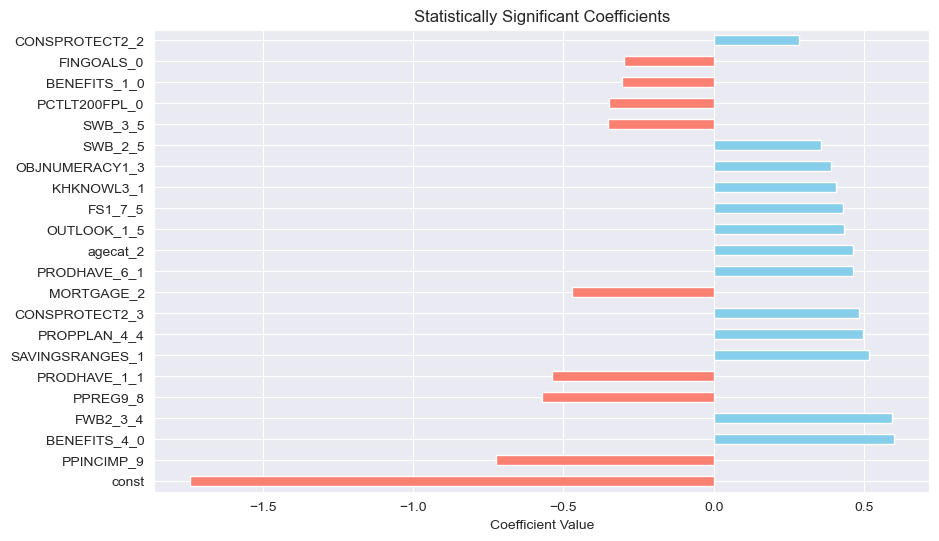

In [18]:
# Get the coefficients and p-values
coefficients = logit_model_reg.params
p_values = logit_model_reg.pvalues

# Create a DataFrame to hold coefficients and p-values for easier processing
coef_df = pd.DataFrame({
    'Coefficient': coefficients,
    'P-Value': p_values
})

# Filter out statistically significant coefficients (e.g., p-value < 0.05)
significant_coefs = coef_df[coef_df['P-Value'] < 0.05]

# Sort coefficients by absolute value (to find the top 20 largest), keeping the sign
top_coefs = significant_coefs['Coefficient'].abs().sort_values(ascending=False).index

# Filter the original coefficients DataFrame to get the top 20 largest coefficients (with signs)
top_coefs_with_signs = significant_coefs.loc[top_coefs]

# Plot the top 20 largest coefficients with their signs
plt.figure(figsize=(10, 6))
top_coefs_with_signs['Coefficient'].plot(kind='barh', color=['skyblue' if coeff >= 0 else 'salmon' for coeff in
                                                             top_coefs_with_signs['Coefficient']])
plt.xlabel('Coefficient Value')
plt.title('Statistically Significant Coefficients')
plt.show()

In [60]:
# take the top coefficients and create a new dataframe
top_features = top_coefs_with_signs.index

# drop the constant column
top_features = top_features.drop('const')

In [61]:
# drop FINGOALS_0, SWB_3_5, and SWB_2_5
top_features = top_features.drop(['FINGOALS_0', 'SWB_3_5', 'SWB_2_5', 'OBJNUMERACY1_3', 'KHKNOWL3_1', 'CONSPROTECT2_2'])

# drop health insurance
top_features = top_features.drop(['BENEFITS_1_0'])

X_train_top = X_train[top_features]
X_test_top = X_test[top_features]

# reset the index
X_train_top.reset_index(drop=True, inplace=True)
X_test_top.reset_index(drop=True, inplace=True)
X_train_top

,PPINCIMP_9,BENEFITS_4_0,FWB2_3_4,PPREG9_8,PRODHAVE_1_1,SAVINGSRANGES_1,PROPPLAN_4_4,CONSPROTECT2_3,MORTGAGE_2,PRODHAVE_6_1,agecat_2,OUTLOOK_1_5,FS1_7_5,PCTLT200FPL_0
0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
2,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5110,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
5111,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
5112,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
5113,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0


In [59]:
X_test_top

,PPINCIMP_9,BENEFITS_4_0,FWB2_3_4,PPREG9_8,PRODHAVE_1_1,SAVINGSRANGES_1,PROPPLAN_4_4,CONSPROTECT2_3,MORTGAGE_2,PRODHAVE_6_1,agecat_2,OUTLOOK_1_5,FS1_7_5,PCTLT200FPL_0
0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
1,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0
3,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0
4,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1274,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1275,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1276,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0
1277,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0


### Inspect Features

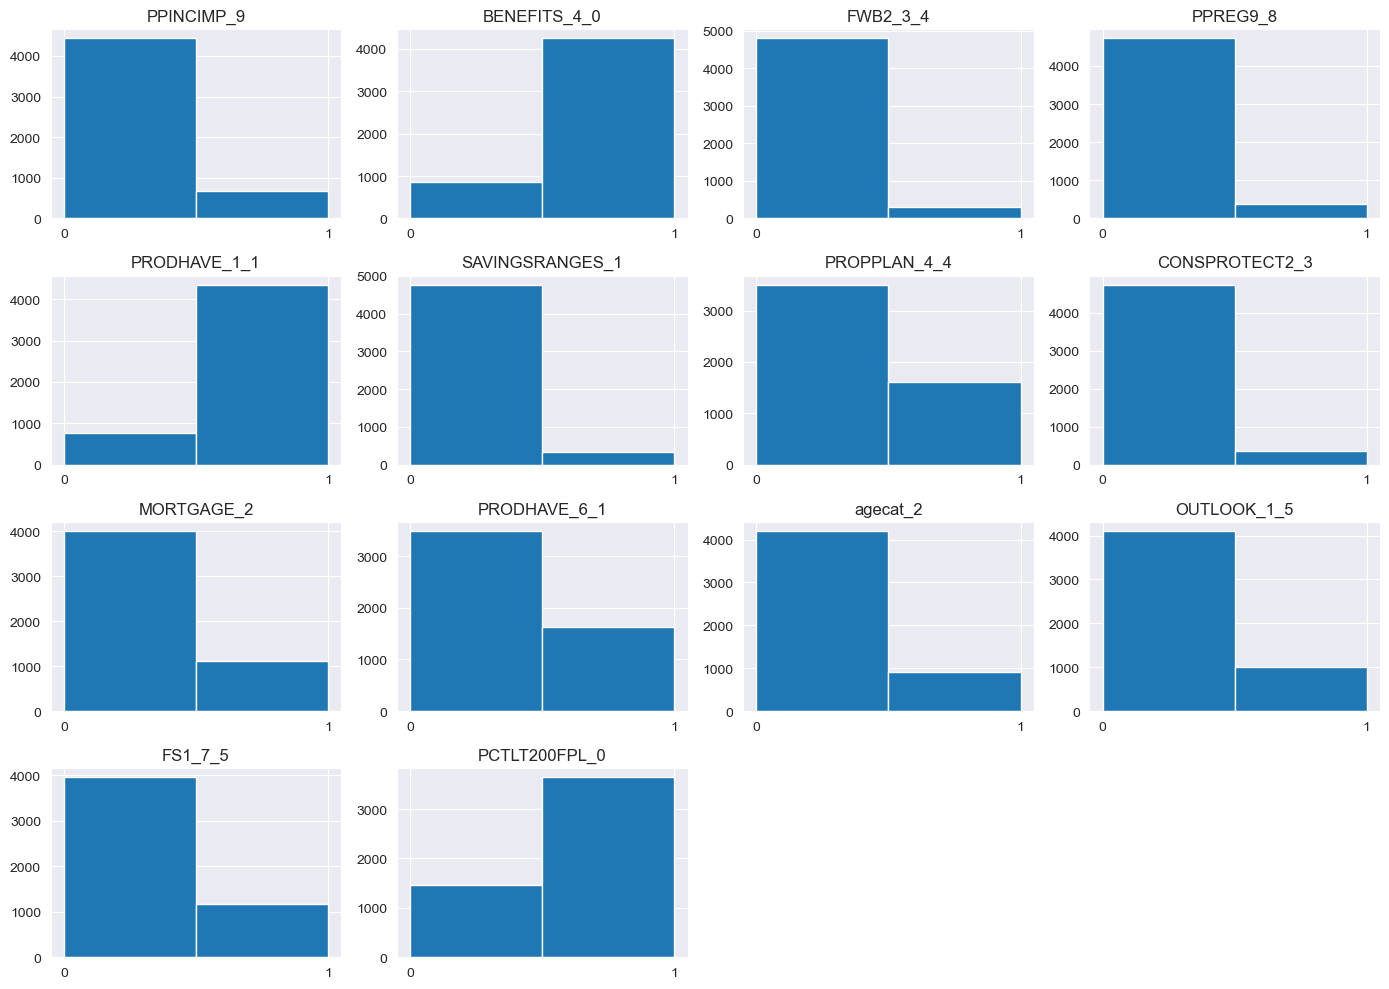

In [21]:
#Inspect the data, check skewness, outliers
axes = X_train_top.hist(bins=2, figsize=(14, 10))
for ax in axes.flatten():
    ax.set_xticks([0, 1])

plt.tight_layout()
plt.show()

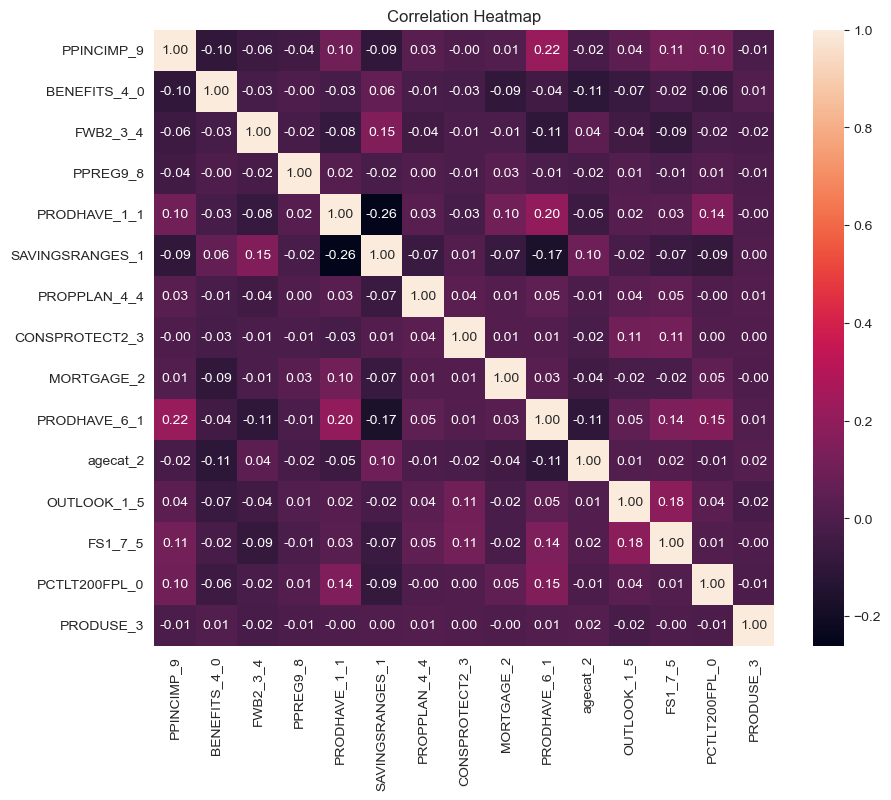

In [22]:
# Correlation heatmap (year and cid are exclued)
combined_df = pd.concat([X_train_top, y], axis=1)
plt.figure(figsize=(10, 8))
sns.heatmap(combined_df.corr(), annot=True, fmt='.2f')
plt.title('Correlation Heatmap')
plt.show()

## Model Building

### Scoring and Cross-Validation

In [66]:
# Define a custom scorer
scorer = make_scorer(f1_score)

In [67]:
# Create a stratified k-fold object to ensure class balance across folds
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

### Logistic Regression

In [68]:
# Logistic Regression
lr_model = LogisticRegression(random_state=42)
lr_model.fit(X_train_top, y_train)

LogisticRegression(random_state=42)

In [69]:
# evaluate the model with default hyperparameters
y_pred_lr_train = lr_model.predict(X_train_top)
y_pred_lr = lr_model.predict(X_test_top)

In [70]:
# Define the parameter distribution for RandomizedSearchCV
param_dist_lr = {
    'penalty': [None],  # Regularization type
    'C': loguniform(1e-4, 1e4),  # Regularization strength (inverse of alpha)
    'solver': ['liblinear', 'saga', 'lbfgs'],  # Solver options
    #'l1_ratio': [0.1, 0.5, 0.9],  # ElasticNet mixing (only for 'elasticnet' penalty)
    'max_iter': randint(100, 5000)  # Max iterations
}


#### RandomizedSearchCV

In [71]:
# Perform GridSearchCV
# Create a GridSearchCV object
logit_random_search = RandomizedSearchCV(
    estimator=lr_model,
    param_distributions=param_dist_lr,
    n_iter=100,
    scoring=scorer,
    cv=cv,
    n_jobs=-1,
    verbose=2,
    random_state=42
)

logit_random_search.fit(X_train_top, y_train)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


/Users/garrinshieh/anaconda3/envs/FINA4390/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/garrinshieh/anaconda3/envs/FINA4390/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/garrinshieh/anaconda3/envs/FINA4390/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/garrinshieh/anaconda3/envs/FINA4390/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/garrinshieh/anaconda3/envs/FINA4390/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio par

RandomizedSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
                   estimator=LogisticRegression(random_state=42), n_iter=100,
                   n_jobs=-1,
                   param_distributions={'C': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x321e65550>,
                                        'max_iter': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x321aeb150>,
                                        'penalty': [None],
                                        'solver': ['liblinear', 'saga',
                                                   'lbfgs']},
                   random_state=42,
                   scoring=make_scorer(f1_score, response_method='predict'),
                   verbose=2)

#### Best Parameters and Best Score

In [72]:
# Print the best parameters and score
print("Best Parameters: ", logit_random_search.best_params_)
print("Best Score: ", logit_random_search.best_score_)

Best Parameters:  {'C': 0.09915644566638401, 'max_iter': 960, 'penalty': None, 'solver': 'lbfgs'}
Best Score:  0.034233409610983985


In [73]:
# evaluate the model with the best hyperparameters
y_pred_lr_hyper_train = logit_random_search.predict(X_train_top)
y_pred_lr_hyper = logit_random_search.predict(X_test_top)

#### Classification Report

In [74]:
# Print the classification report
print(classification_report(y_test, y_pred_lr_hyper))

              precision    recall  f1-score   support

           0       0.91      1.00      0.95      1167
           1       0.38      0.03      0.05       112

    accuracy                           0.91      1279
   macro avg       0.64      0.51      0.50      1279
weighted avg       0.87      0.91      0.87      1279



#### Threshold Optimization

In [75]:
# Find the optimal threshold
y_prob_train = logit_random_search.predict_proba(X_train_top)[:, 1]
y_prob = logit_random_search.predict_proba(X_test_top)[:, 1]

# Calculate precision, recall, and thresholds
precision, recall, thresholds = precision_recall_curve(y_test, y_prob)

# Choose a threshold based on the desired balance of precision and recall
f1_scores = 2 * (precision * recall) / (precision + recall)
best_threshold = thresholds[np.argmax(f1_scores)]

print(f"Optimal threshold for best F1-score: {best_threshold}")

Optimal threshold for best F1-score: 0.14753005576135164


In [76]:
# Evaluate the model with the optimal threshold
y_pred_lr_optimal_train = (y_prob_train >= best_threshold).astype(int)
y_pred_lr_optimal = (y_prob >= best_threshold).astype(int)

# Print the classification report
print(classification_report(y_test, y_pred_lr_optimal))

              precision    recall  f1-score   support

           0       0.94      0.86      0.90      1167
           1       0.21      0.39      0.28       112

    accuracy                           0.82      1279
   macro avg       0.58      0.63      0.59      1279
weighted avg       0.87      0.82      0.84      1279



### Random Forest

In [77]:
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train_top, y_train)

RandomForestClassifier(random_state=42)

In [78]:
# evaluate the model with default hyperparameters
y_pred_rf_train = rf_model.predict(X_train_top)
y_pred_rf = rf_model.predict(X_test_top)

In [79]:
# Define the parameter distribution for RandomizedSearchCV
param_dist_rf = {
    'n_estimators': randint(200, 1200),  # Number of trees in the forest
    'max_depth': randint(5, 15),  # Maximum depth of the tree
    'min_samples_split': randint(2, 20),  # Minimum number of samples required to split an internal node
    'min_samples_leaf': randint(1, 20),  # Minimum number of samples required to be at a leaf node
    'max_features': ['sqrt', 'log2', None],  # Number of features to consider when looking for the best split
    'bootstrap': [True, False],  # Whether bootstrap samples are used when building trees
    'class_weight': ['balanced', 'balanced_subsample', None]  # Weights associated with classes
}

#### RandomizedSearchCV

In [80]:
rf_random_search = RandomizedSearchCV(
    estimator=rf_model,
    param_distributions=param_dist_rf,
    n_iter=100,
    scoring=scorer,
    cv=cv,
    n_jobs=-1,
    verbose=2,
    random_state=42
)

rf_random_search.fit(X_train_top, y_train)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


RandomizedSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
                   estimator=RandomForestClassifier(random_state=42),
                   n_iter=100, n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'class_weight': ['balanced',
                                                         'balanced_subsample',
                                                         None],
                                        'max_depth': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x30c8f5810>,
                                        'max_features'...
                                        'min_samples_leaf': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x321c9e590>,
                                        'min_samples_split': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x30c8f7e90>,
                                        'n_estimators': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x321c76050>},
                   random_state=42,
                   scoring=make_scorer(f1_score, response_method='predict'),
                   verbose=2)

#### Best Parameters and Best Score

In [81]:
# Print the best parameters and score
print("Best Parameters: ", rf_random_search.best_params_)
print("Best Score: ", rf_random_search.best_score_)

Best Parameters:  {'bootstrap': True, 'class_weight': 'balanced', 'max_depth': 9, 'max_features': 'log2', 'min_samples_leaf': 7, 'min_samples_split': 15, 'n_estimators': 422}
Best Score:  0.2579007124982189


In [82]:
# evaluate the model with the best hyperparameters
y_pred_rf_hyper_train = rf_random_search.predict(X_train_top)
y_pred_rf_hyper = rf_random_search.predict(X_test_top)

#### Classification Report

In [83]:
# Print the classification report
print(classification_report(y_test, y_pred_rf_hyper))

              precision    recall  f1-score   support

           0       0.94      0.70      0.80      1167
           1       0.14      0.52      0.22       112

    accuracy                           0.69      1279
   macro avg       0.54      0.61      0.51      1279
weighted avg       0.87      0.69      0.75      1279



### XGBoost

In [84]:
xgb_model = XGBClassifier(random_state=42)
xgb_model.fit(X_train_top, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=42, ...)

In [85]:
# evaluate the model with default hyperparameters
y_pred_xgb_train = xgb_model.predict(X_train_top)
y_pred_xgb = xgb_model.predict(X_test_top)

In [86]:
# Define the parameter distribution for GridSearchCV
param_distributions_xgb = {
    'n_estimators': randint(50, 1000),  # Number of boosting rounds
    'learning_rate': uniform(0.01, 0.5),  # Step size shrinkage
    'max_depth': randint(3, 10),  # Maximum depth of a tree
    'min_child_weight': randint(1, 6),  # Minimum sum of instance weight (hessian) needed in a child
    'gamma': uniform(0, 1),  # Minimum loss reduction to make a split
    'subsample': uniform(0.1, 0.9),  # Subsample ratio of the training data
    'colsample_bytree': uniform(0.1, 0.9),  # Subsample ratio of columns when constructing each tree
    'scale_pos_weight': randint(1, 10),  # Controls the balance of positive and negative classes
}

#### RandomizedSearchCV

In [87]:
xgb_random_search = RandomizedSearchCV(
    estimator=xgb_model,
    param_distributions=param_distributions_xgb,
    n_iter=100,
    scoring=scorer,
    cv=cv,
    n_jobs=-1,
    verbose=2,
    random_state=42
)

xgb_random_search.fit(X_train_top, y_train, verbose=False)

Fitting 5 folds for each of 100 candidates, totalling 500 fits
[CV] END C=0.09915644566638401, max_iter=960, penalty=None, solver=lbfgs; total time=   0.0s
[CV] END C=0.00014610865886287216, max_iter=869, penalty=None, solver=saga; total time=   0.0s
[CV] END C=0.004997040685255816, max_iter=1284, penalty=None, solver=saga; total time=   0.1s
[CV] END C=0.0023130924416844114, max_iter=2535, penalty=None, solver=liblinear; total time=   0.0s
[CV] END C=0.0023130924416844114, max_iter=2535, penalty=None, solver=liblinear; total time=   0.0s
[CV] END C=5309.5322690092235, max_iter=341, penalty=None, solver=saga; total time=   0.0s
[CV] END C=5309.5322690092235, max_iter=341, penalty=None, solver=saga; total time=   0.0s
[CV] END C=0.13442649050633507, max_iter=1685, penalty=None, solver=saga; total time=   0.1s
[CV] END C=0.13442649050633507, max_iter=1685, penalty=None, solver=saga; total time=   0.0s
[CV] END C=0.003697114486625516, max_iter=1116, penalty=None, solver=saga; total time= 

RandomizedSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           callbacks=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None, device=None,
                                           early_stopping_rounds=None,
                                           enable_categorical=False,
                                           eval_metric=None, feature_types=None,
                                           gamma=None, grow_policy=None,
                                           importan...
                                        'n_estimators': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x321a97350>,
                                        'scale_pos_weight': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x321982350>,
                                        'subsample': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x321c5fd90>},
                   random_state=42,
                   scoring=make_scorer(f1_score, response_method='predict'),
                   verbose=2)

#### Best Parameters and Best Score

In [88]:
# Print the best parameters and score
print("Best Parameters: ", xgb_random_search.best_params_)
print("Best Score: ", xgb_random_search.best_score_)

Best Parameters:  {'colsample_bytree': 0.1349512609864809, 'gamma': 0.3032655146732228, 'learning_rate': 0.27854121359832773, 'max_depth': 7, 'min_child_weight': 1, 'n_estimators': 313, 'scale_pos_weight': 5, 'subsample': 0.3443886242377677}
Best Score:  0.2692687239263739


In [89]:
# evaluate the model with the best hyperparameters
y_pred_xgb_hyper_train = xgb_random_search.predict(X_train_top)
y_pred_xgb_hyper = xgb_random_search.predict(X_test_top)

#### Classification Report

In [90]:
# Print the classification report
print(classification_report(y_test, y_pred_xgb_hyper))

              precision    recall  f1-score   support

           0       0.92      0.91      0.92      1167
           1       0.19      0.23      0.21       112

    accuracy                           0.85      1279
   macro avg       0.56      0.57      0.56      1279
weighted avg       0.86      0.85      0.85      1279



## Results

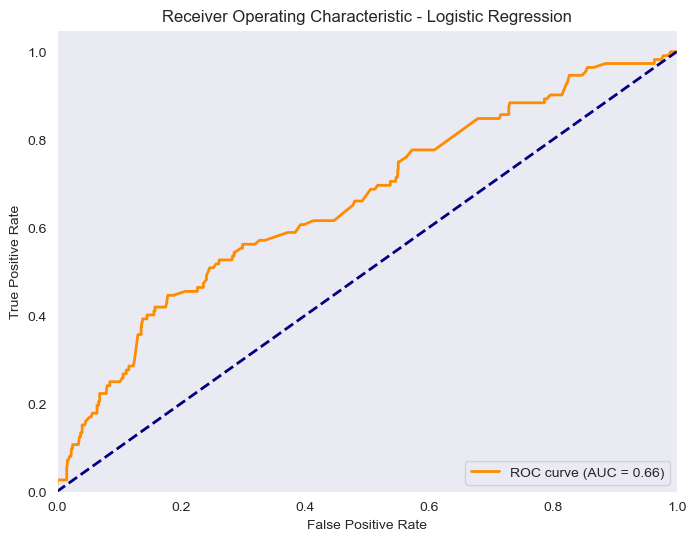

In [91]:
# plot roc curve for logistic regression
utils.plot_roc_curve(y_test, y_prob, 'Logistic Regression')

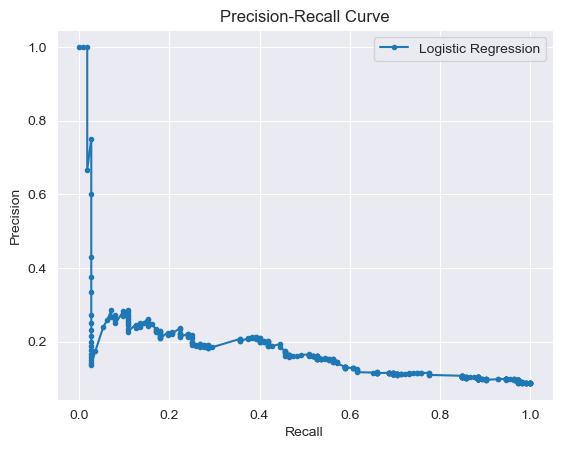

In [92]:
# plot precision-recall curve for logistic regression
precision, recall, thresholds = precision_recall_curve(y_test, y_prob)
plt.plot(recall, precision, marker='.', label='Logistic Regression')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.show()

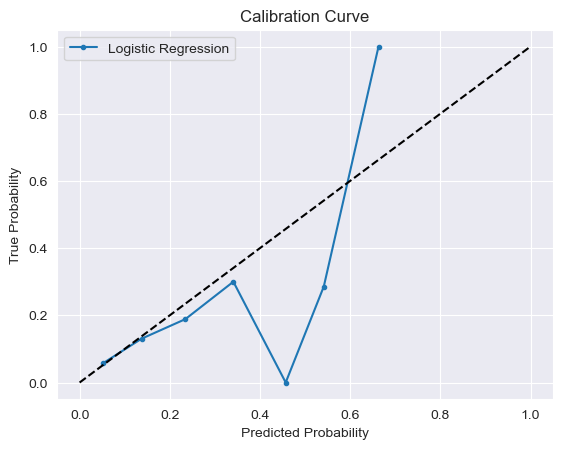

In [93]:
# plot calibration curve for logistic regression

prob_true, prob_pred = calibration_curve(y_test, y_prob, n_bins=10)
plt.plot(prob_pred, prob_true, marker='.', label='Logistic Regression')
plt.plot([0, 1], [0, 1], linestyle='--', color='black')
plt.xlabel('Predicted Probability')
plt.ylabel('True Probability')
plt.title('Calibration Curve')
plt.legend()
plt.show()

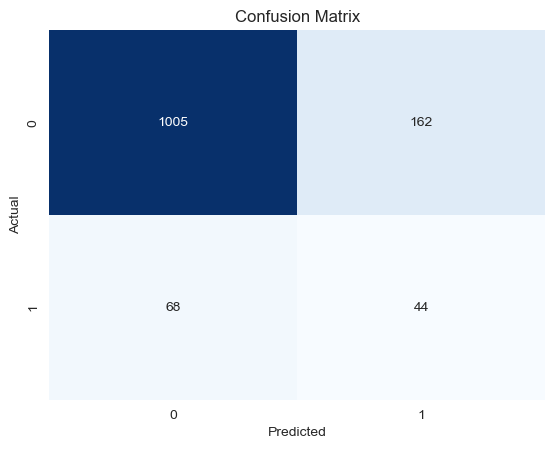

In [94]:
# plot confusion matrix for logistic regression
cm = confusion_matrix(y_test, y_pred_lr_optimal)
plt.plot()
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

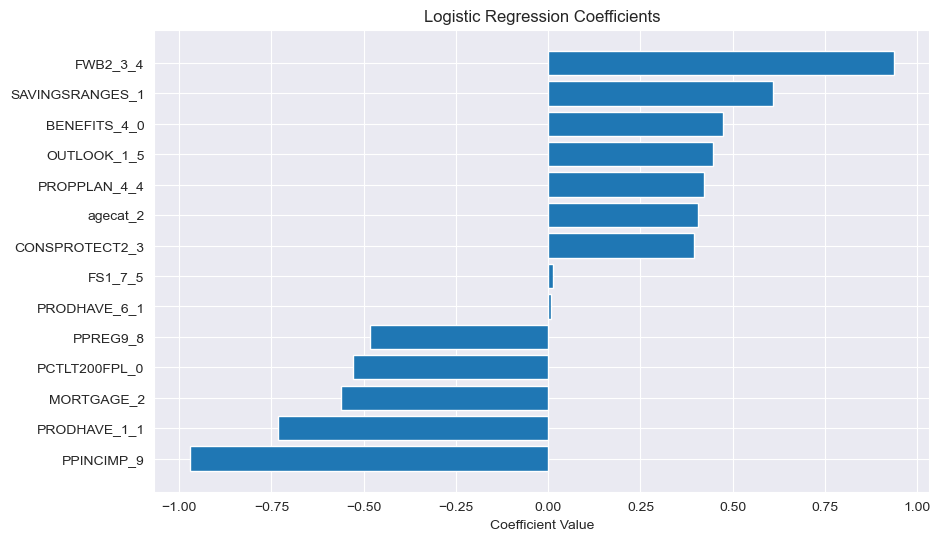

In [95]:
# plot coefficients for logistic regression
plt.figure(figsize=(10, 6))
# from the sklearn model
coefs = logit_random_search.best_estimator_.coef_[0]
# sort the coefficients
coefs, X_train_top.columns = zip(*sorted(zip(coefs, X_train_top.columns)))
# plot the coefficients
plt.barh(X_train_top.columns, coefs)
plt.xlabel('Coefficient Value')
plt.title('Logistic Regression Coefficients')
plt.show()

In [99]:
models = ['Logistic Regression', 'Random Forest', 'XGBoost']
predictions_base_train = [y_pred_lr_hyper_train, y_pred_rf_train, y_pred_xgb_train]
predictions_hyper_train = [y_pred_lr_optimal_train, y_pred_rf_hyper_train, y_pred_xgb_hyper_train]
predictions_base_test = [y_pred_lr_hyper, y_pred_rf, y_pred_xgb]
predictions_hyper_test = [y_pred_lr_optimal, y_pred_rf_hyper, y_pred_xgb_hyper]

results = utils.evaluate_models(models=models, predictions_base_train=predictions_base_train,
                                predictions_hyper_train=predictions_hyper_train,
                                predictions_base_test=predictions_base_test,
                                predictions_hyper_test=predictions_hyper_test,
                                X=X_test_top, y_train=y_train, y_test=y_test)
results

,,Logistic Regression,Random Forest,XGBoost,Best Model,Best Value
Metric,Type,,,,,
Accuracy,Train - Base,0.912805,0.92825,0.923363,Logistic Regression,0.910868
Overall Precision,Train - Base,0.884655,0.924863,0.916324,Logistic Regression,0.873311
Overall Recall,Train - Base,0.912805,0.92825,0.923363,Logistic Regression,0.910868
Overall F1 Score,Train - Base,0.873428,0.907473,0.898817,Logistic Regression,0.874145
Positive Precision,Train - Base,0.583333,0.878505,0.825581,Logistic Regression,0.375000
Negative Precision,Train - Base,0.91358,0.929313,0.925035,Random Forest,0.938215
Positive Recall,Train - Base,0.015625,0.209821,0.158482,Random Forest,0.517857
Negative Recall,Train - Base,0.998929,0.997214,0.996786,Logistic Regression,0.995716
Positive F1 Score,Train - Base,0.030435,0.338739,0.265918,Logistic Regression,0.276730
